In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

def loadData(path):
    global idFile
    data = pd.read_csv(path)
    data['Time'] = 0
    for t,i in enumerate(data.index[data['Label']==1]):
        data.loc[data.index>i,'Time'] = t
    data = data.rename(columns={'CX (unit)':'X','CY (unit)':'Y','CZ (unit)':'Z','Vol (unit)':'Volume'})[['X','Y','Z','Volume','Time']]
    data['X'] *= 0.32
    data['Y'] *= 0.32
    data['Z'] -= 150
    data.loc[:,['X','Y']] = (data.set_index('Time')[['X','Y']] - data.groupby('Time')[['X','Y']].mean()).reset_index()
    data['centerDist'] = np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)
    data = data[data['centerDist']<150]
    data['radius'] = (data['Volume']/(4/3*np.pi))**(1/3)
    labels = [*["{0} - {1}".format(i, i + 5) for i in range(0, 30, 5)],'> 30']
    data["Foci"] = pd.cut(data.radius, [*np.arange(0,14,2),999], right=False, labels=labels)
    data
    stepSize = 15
    labels = ["{0} - {1}".format(i, i + stepSize) for i in range(0, int(np.ceil(data["centerDist"].max())), stepSize)]
    data['condition'] = re.match(r'.*\d+(?P<condition>\w+)3DResults\.csv',path)['condition']
    data['id'] = idFile
    idFile += 1
    return data

idFile = 0
allData = pd.concat([loadData(path) for path in glob.glob('/Users/lorenzo/Desktop/CSV/*.csv', recursive=False)],ignore_index=True)

# Preview the first few rows of allData
print(allData.head())

# Save allData to a CSV file
allData.to_csv('/Users/lorenzo/Desktop/allData.csv', index=False)


           X          Y      Z  Volume  Time  centerDist    radius    Foci  \
0   0.882376  -3.464554 -147.0    27.0     0  147.043469  1.861051   0 - 5   
1  29.042376   0.695446 -147.0    27.0     0  149.843062  1.861051   0 - 5   
2  15.282376  15.415446 -145.0   251.0     0  146.615780  3.913167  5 - 10   
3  33.202376  21.815446 -141.0   251.0     0  146.489970  3.913167  5 - 10   
4 -31.437624   2.615446 -142.0    27.0     0  145.461901  1.861051   0 - 5   

  condition  id  
0        NT   0  
1        NT   0  
2        NT   0  
3        NT   0  
4        NT   0  


<Axes: title={'center': 'control radius (from Volume)'}>

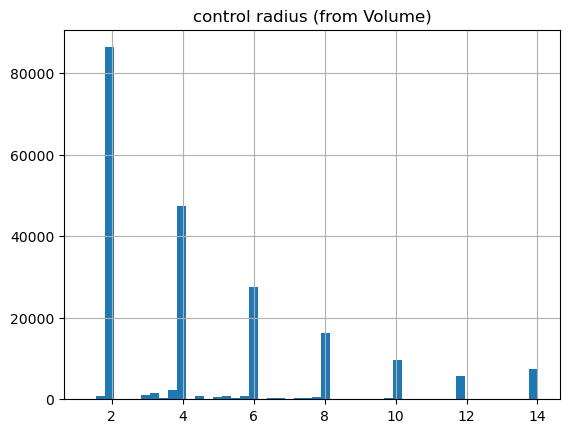

In [2]:
plt.title('control radius (from Volume)')
allData.radius.hist(bins=50)

In [3]:
nbDistGroup = 2


allData['distGroup'] = pd.qcut(allData['centerDist'],nbDistGroup)
b=[f'{round(a.left) if i>0 else 0} - {round(a.right)}' for i,a in enumerate(allData['distGroup'].unique().sort_values())]
b=dict(zip(allData['distGroup'].unique().sort_values(),b))
allData['distGroup'] = allData['distGroup'].replace(b)

/Users/lorenzo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


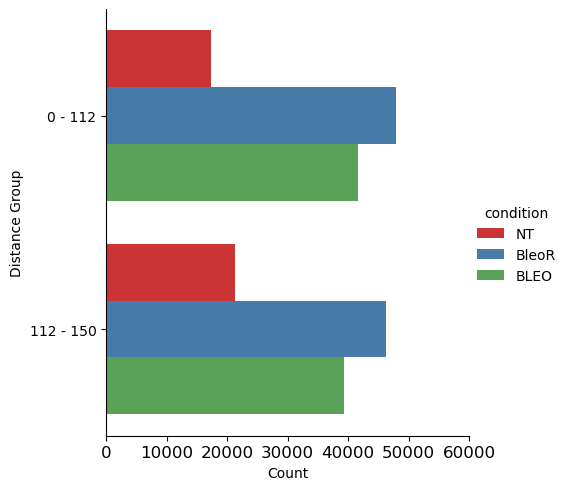

In [4]:
graph = sns.catplot(data=allData, y='distGroup', hue='condition', kind='count', palette='Set1')

# Modification de la taille du texte
graph.set_axis_labels("Count", "Distance Group").set_xticklabels(fontsize=12)

# Sauvegarde du graphique
graph.savefig("graphique.png")

# Affichage du graphique
plt.show()


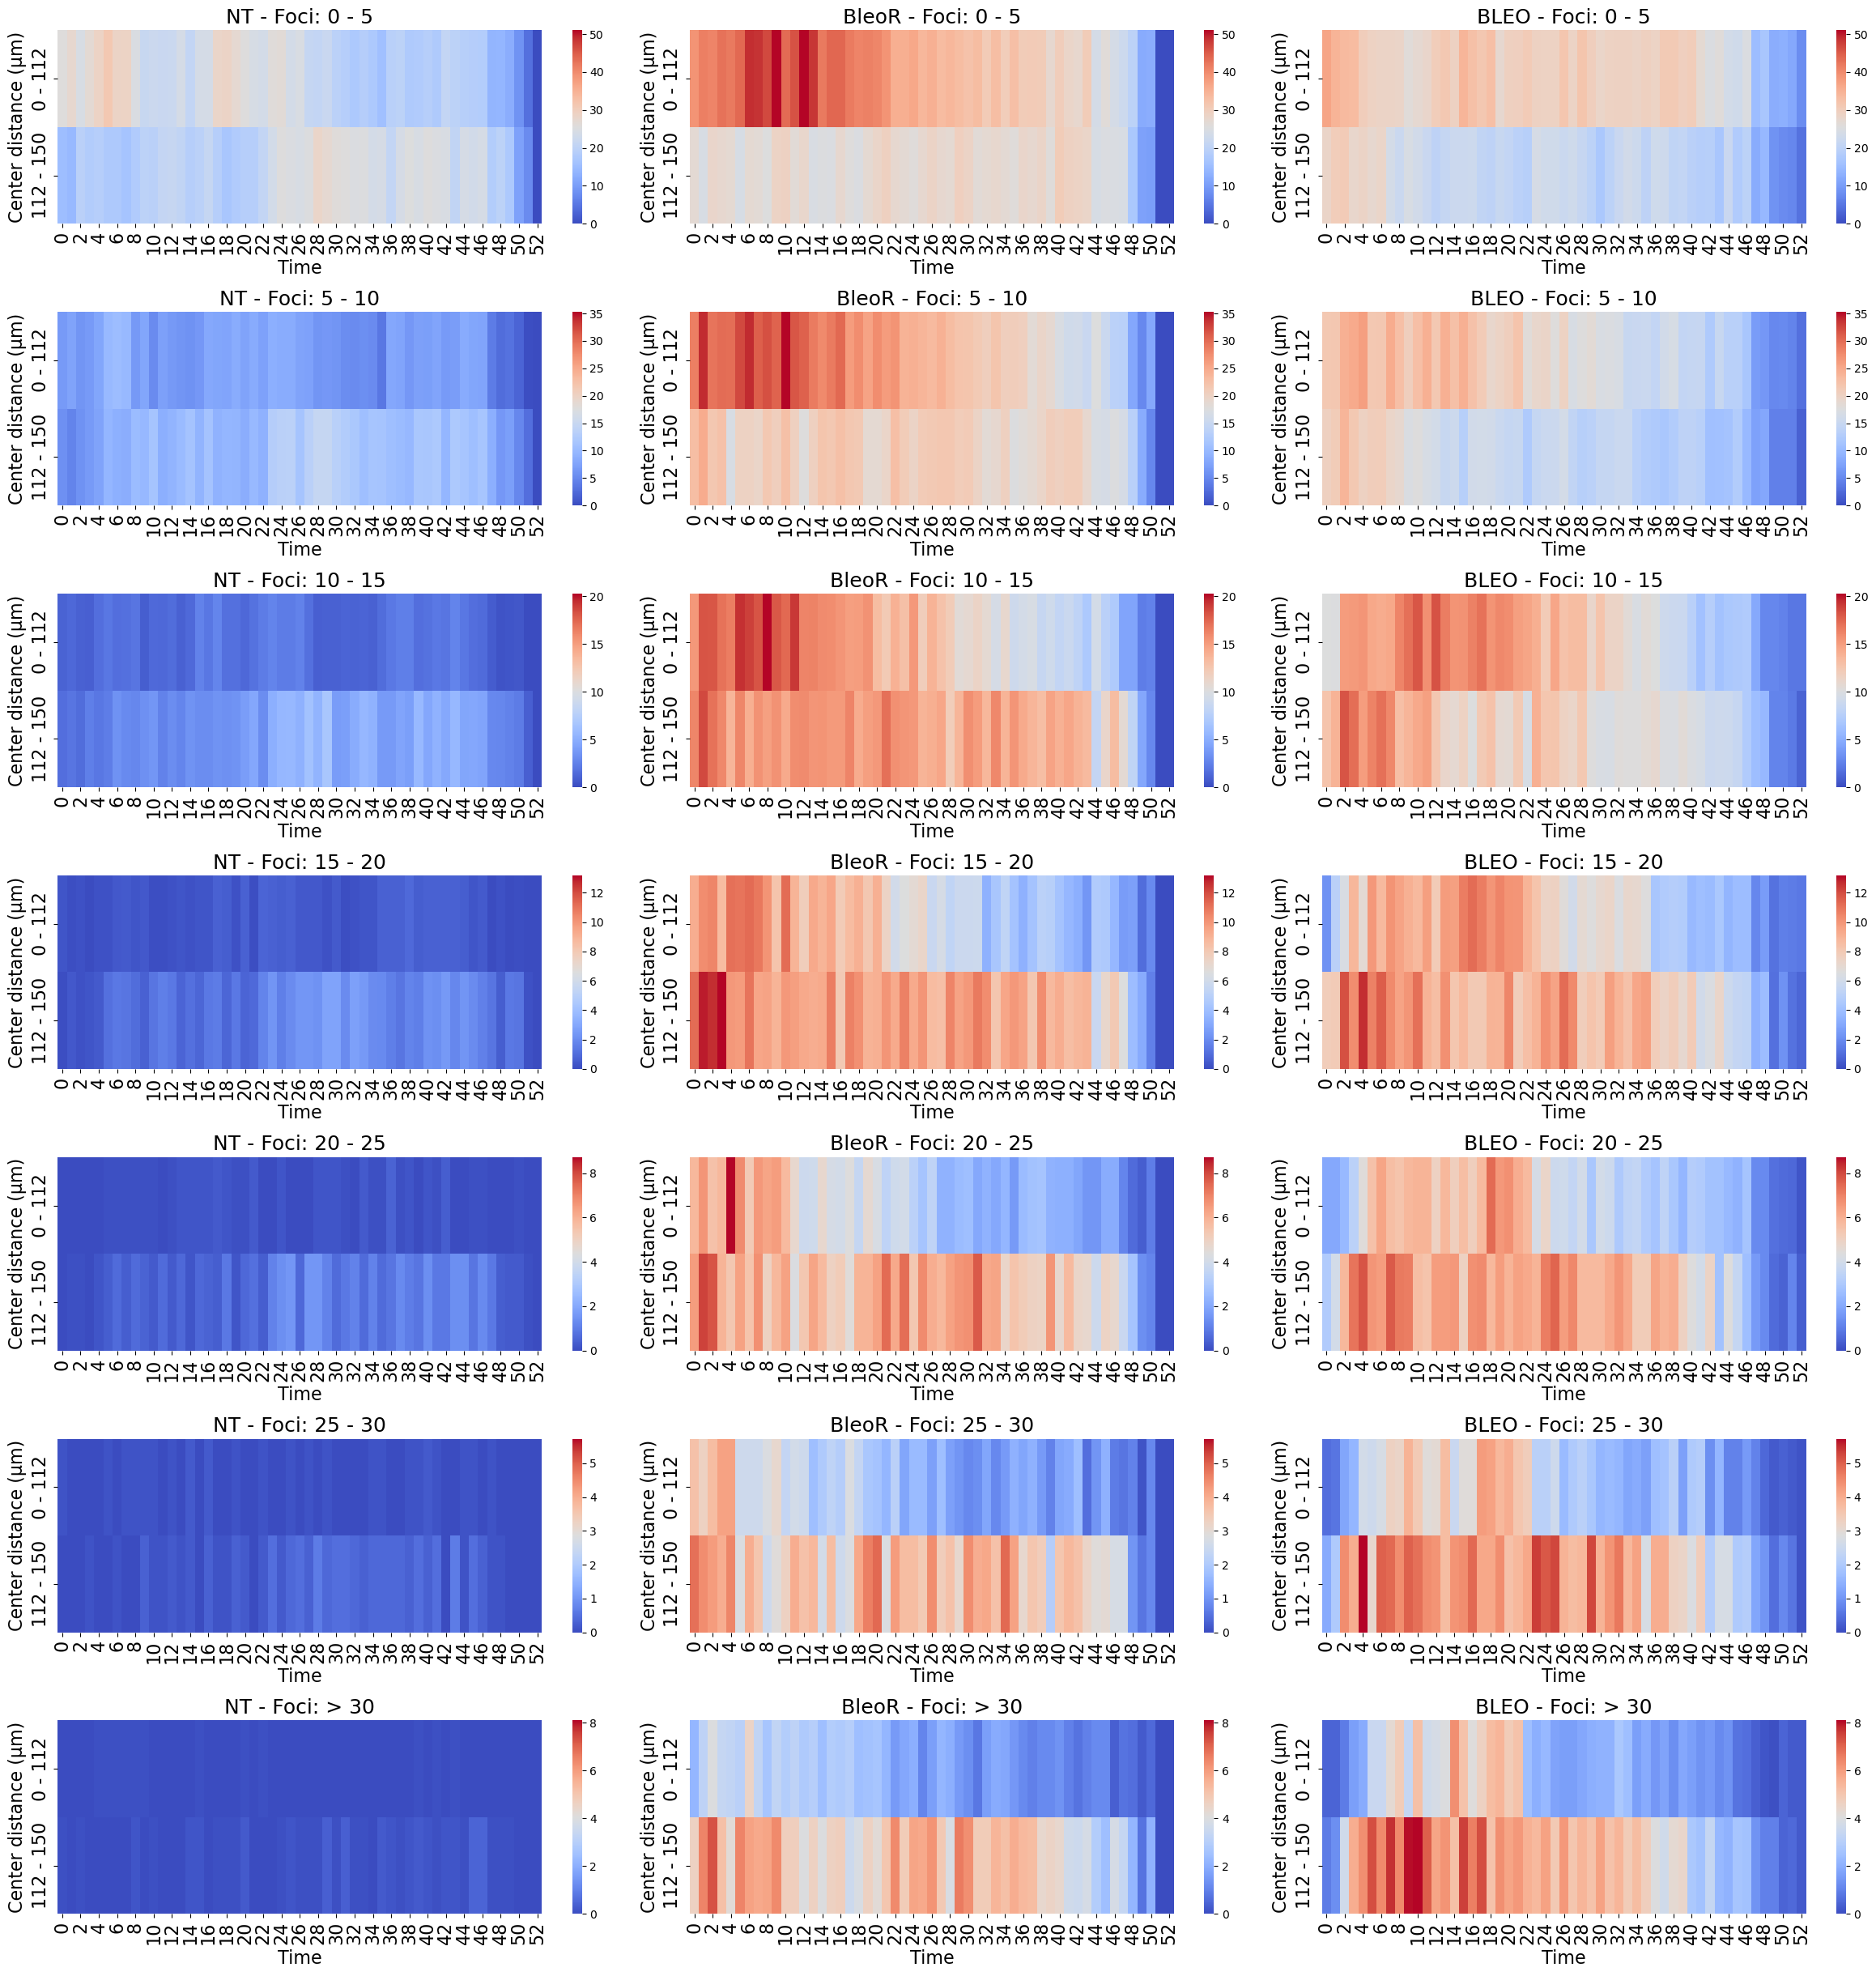

In [5]:
# Configuration
subplotSize = (8, 3.5)
sameColorScale = False
conditions = ['NT', 'BleoR', 'BLEO']
labelFoci = [f"{i} - {i + 5}" for i in range(0, 30, 5)] + ['> 30']

# Calcul de la moyenne des comptes de foci par groupe
allDataCountMean = (allData.groupby(['Time', 'distGroup', 'Foci', 'condition', 'id'])['X']
                    .count()
                    .fillna(0)
                    .droplevel('id')
                    .groupby(['Time', 'distGroup', 'Foci', 'condition'])
                    .mean()
                    .unstack('Time'))

# Valeur maximale pour l'échelle de couleur
valueMax = allDataCountMean.max().max()

# Création de la figure avec sous-graphes
fig, axs = plt.subplots(len(labelFoci), len(conditions),
                        figsize=(subplotSize[0] * len(conditions), subplotSize[1] * len(labelFoci)))

# Paramètres de taille de police
title_fontsize = 18
axis_label_fontsize = 16
axis_tick_fontsize = 16

# Palette de couleurs
cmap = 'coolwarm'  # Choisissez une palette de couleurs, par exemple 'viridis', 'plasma', 'coolwarm', etc.

# Parcours des groupes de données
for foci, dfFoci in allDataCountMean.groupby('Foci'):
    i = labelFoci.index(foci)
    if not sameColorScale:
        valueMax = dfFoci.max().max()

    for cond, dfCond in dfFoci.groupby('condition'):
        j = conditions.index(cond)
        sns.heatmap(dfCond.droplevel(['Foci', 'condition']), ax=axs[i, j], vmin=0, vmax=valueMax, cmap=cmap)
        axs[i, j].set_ylabel('Center distance (μm)', fontsize=axis_label_fontsize)
        axs[i, j].set_xlabel('Time', fontsize=axis_label_fontsize)
        axs[i, j].set_title(f'{cond} - Foci: {foci}', fontsize=title_fontsize)
        axs[i, j].tick_params(axis='both', which='major', labelsize=axis_tick_fontsize)

# Ajustement de la mise en page et sauvegarde du graphique
plt.tight_layout()
plt.savefig('heatmap_comparison.png', format='png')
plt.show()
